# Bottom-up model

Our objective is to create a simulator scenario. It should model how our orders would behave if we changed a few parameters.

##### Imports

In [1]:
import numpy as np
import pandas as pd
import s3fs
import fbprophet
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics

#### Reading data
We will gather the necessary information to fit our prediction models.  
Our dataframes are hosted in s3.

In [2]:
data = pd.read_csv('s3://bsa-correlation-one/electronics_data.csv', dtype={'gtin':'str'})

In [3]:
data.head(1)

,Unnamed: 0,date,competition_price,gtin,item_name,enable_subsidy,gmv,revenue,cogs,gross_profit,...,stock_min,stock_avg,price_max,price_min,price_avg,offer_max,offer_min,offer_avg,product_type,product_group
0,0,2019-05-06,NaN,7435315014405,Dongle Cast Ezcast Adaptador Hdmi Anycast Weca...,NaN,0.0,0.0,0.0,0.0,...,5.0,27.5,69.99,69.99,69.99,69.99,69.99,69.99,Adaptador eletrônico,electronics


In [ ]:
#data['delta_price'] = (data.olist_price.values/data.competition_price.values)-1

In [3]:
#df = data[['date', 'product_group','product_type', 'olist_price','delta_price', 'orders']].copy()
df = data[['date', 'product_group','product_type', 'olist_price','competition_price','freight_value','stock_max', 'orders']].copy()

In [4]:
df.loc[(df["competition_price"].isnull()) & (df['orders']>0),'competition_price'] = df['olist_price']

In [5]:
df['olist_price'] = round(df.olist_price,2)
df['competition_price'] = round(df.competition_price,2)

In [ ]:
#df['delta_price'] = round(df.delta_price,3)

In [6]:
df.head(2)

,date,product_group,product_type,olist_price,competition_price,freight_value,stock_max,orders
0,2019-05-06,electronics,Adaptador eletrônico,69.99,NaN,NaN,50.0,0.0
1,2019-05-07,electronics,Adaptador eletrônico,69.99,NaN,NaN,50.0,0.0


### Create price categories

Working with each product individually would be infeasible, as some of them have extremely short and/or volatile and/or sparse time series. In order to mitigate such behaviors, we grouped each product taking its type and price range into consideration.  
For example: Cellphones prices were categorized with respect to the prices distribution for this product type. Every product that had lower prices than its 25-th percentile was categorized as 'A', then 'B' for products cheaper than the 50-th percentile, 'C' for products cheaper then the 75-th percentile. All other products were categorized as 'D'.  
Then, we finally concatenate the product's group, type and price range category into one column.
A different model will be fit to each of these combinations.

In [7]:
price_cat = {}
for prod_type in df.product_type.unique():
    temp = df[df.product_type == prod_type].copy()
    price_cat[prod_type] = np.quantile(temp.olist_price.values, np.arange(0.25,1,0.25))

In [8]:
def price_range(prod_category, price):
    prices = price_cat[prod_category]
    if price < prices[0]:
        return 'A'
    elif price < prices[1]:
        return 'B'
    elif price < prices[2]:
        return 'C'
    else:
        return 'D'

In [9]:
df['price_category'] = df.apply(lambda row: price_range(row['product_type'], row['olist_price']), axis=1)

In [ ]:
#df_gr = df.groupby(['date','product_group','product_type','price_category'])\
#          .agg({'orders':'sum', 'delta_price': 'mean'}).reset_index()

In [10]:
df_gr = df.groupby(['date','product_group','product_type','price_category'])\
          .agg({'olist_price': 'mean', 'competition_price':'mean', 'freight_value':'mean',
                'stock_max':'sum', 'orders':'sum'}).reset_index()

In [12]:
df_gr.head()

,date,product_group,product_type,price_category,olist_price,competition_price,freight_value,stock_max,orders
0,2017-06-30,electronics,Celular,A,149.90,NaN,NaN,20.0,0.0
1,2017-06-30,electronics,Celular,B,349.90,NaN,NaN,10.0,0.0
2,2017-06-30,electronics,Celular,C,813.63,NaN,NaN,5.0,0.0
3,2017-06-30,electronics,Controle remoto,D,42.50,NaN,NaN,0.0,0.0
4,2017-06-30,electronics,Microfone,A,39.95,NaN,NaN,0.0,0.0


In [13]:
df_gr['group_type_price'] = df_gr.product_group + '_' + df_gr.product_type + '_' +df_gr.price_category

In [14]:
#df_final = df_gr[['date','group_type_price','delta_price', 'orders']].copy()
df_final = df_gr[['date','group_type_price','olist_price', 'competition_price','freight_value', 'stock_max', 'orders']].copy()

In [15]:
df_final['date'] = pd.to_datetime(df_final['date'])

In [16]:
df_final.rename(columns={'date':'ds', 'orders':'y'}, inplace=True)

In [17]:
df_final.head()

,ds,group_type_price,olist_price,competition_price,freight_value,stock_max,y
0,2017-06-30,electronics_Celular_A,149.90,NaN,NaN,20.0,0.0
1,2017-06-30,electronics_Celular_B,349.90,NaN,NaN,10.0,0.0
2,2017-06-30,electronics_Celular_C,813.63,NaN,NaN,5.0,0.0
3,2017-06-30,electronics_Controle remoto_D,42.50,NaN,NaN,0.0,0.0
4,2017-06-30,electronics_Microfone_A,39.95,NaN,NaN,0.0,0.0


### Holidays

Let's create a dataframe with the most important holidays that could affect sales.

In [18]:
def get_holidays():
    """
    Get Black Friday dates
    """
    black_friday = pd.DataFrame({
                  'holiday': 'black_friday',
                  'ds': pd.to_datetime(['2017-11-24', '2018-11-23', '2019-11-29',
                                        '2020-11-27', '2021-11-26', '2022-11-25',
                                        '2023-11-24', '2024-11-29', '2025-11-28']),
                  'lower_window': -1,
                  'upper_window': 3,
                })

    xmas = pd.DataFrame({
                  'holiday': 'christmas',
                  'ds': pd.to_datetime(['2017-12-25', '2018-12-25', '2019-12-25',
                                        '2020-12-25', '2021-12-25', '2022-12-25',
                                        '2023-12-25', '2024-12-25', '2025-12-25']),
                  'lower_window': -1,
                  'upper_window': 0,
                })

    new_year = pd.DataFrame({
                  'holiday': 'new_year',
                  'ds': pd.to_datetime(['2017-01-01', '2018-01-01', '2019-01-01',
                                        '2020-01-01', '2021-01-01', '2022-01-01',
                                        '2023-01-01', '2024-01-01', '2025-01-01']),
                  'lower_window': -1,
                  'upper_window': 0,
                })

    carnival = pd.DataFrame({
                  'holiday': 'carnival',
                  'ds': pd.to_datetime(['2017-02-28', '2018-02-13', '2019-03-05',
                                        '2020-02-25', '2021-02-16', '2022-03-01',
                                        '2023-02-21', '2024-02-13', '2025-03-04']),
                  'lower_window': -1,
                  'upper_window': 0,
                })

    good_friday = pd.DataFrame({
                  'holiday': 'good_friday',
                  'ds': pd.to_datetime(['2018-03-18','2019-04-19','2020-04-10',
                                        '2021-04-02','2022-04-15','2023-04-07',
                                        '2024-03-29']),
                  'lower_window': 0,
                  'upper_window': 2,
                })

    # long holidays

    monday = pd.DataFrame({
                  'holiday': 'monday',
                  'ds': pd.to_datetime(['2020-09-07','2020-10-12','2020-11-02',
                                        '2021-11-15']),
                  'lower_window': -2,
                  'upper_window': 0,
                })

    friday = pd.DataFrame({
                  'holiday': 'friday',
                  'ds': pd.to_datetime(['2018-09-07','2018-10-12','2018-11-02',
                                        '2019-11-15','2020-05-01']),
                  'lower_window': 0,
                  'upper_window': 2,
                })

    # Different cases
    # 2019-12-30 (christmas and New year's eve from tuesday to wednesday. Monday was also affected)
    others = pd.DataFrame({
                  'holiday': 'others',
                  'ds': pd.to_datetime(['2019-12-23','2019-12-30']),
                  'lower_window': 0,
                  'upper_window': 0,
                })

    holidays = pd.concat((black_friday, xmas, new_year, carnival,
                         monday, friday, others))

    return holidays

In [19]:
holidays = get_holidays()

### Bottom-up prophet

Below, you can see the first draft of the modeling process.  
In the example below, we predicted a few scenarios for the cheapest (price category 'A') for cellphones.

# Create models
We start by fitting models for each product group_type_pricerange. We then save such models to a dictionary.

In [20]:
start = datetime.now()
models = {}
#deltas = {}
olist = {}
competition = {}
freight = {}
#inventory = {}

for each in df_final.group_type_price.unique(): # each in df_final.group_type_price.unique()['electronics_Celular_A']
    try:
        temp = df_final[df_final['group_type_price']==each].copy()
        temp.reset_index(drop=True, inplace=True)
        first_valid = temp[temp.competition_price.notnull()].index[0]
        temp = temp.iloc[first_valid:]
        
        # fillna values with mean?
        #temp['delta_price'] = temp.delta_price.fillna(value=temp.delta_price.mean())
        #deltas[each] = temp['delta_price'].tolist()
        temp['olist_price'].fillna(method='ffill',inplace=True)
        temp['competition_price'].fillna(method='ffill',inplace=True)
        temp['freight_value'].fillna(method='ffill',inplace=True)
        temp['freight_value'].fillna(value=temp['freight_value'].median(), inplace=True)
        
        olist[each] = temp['olist_price'].tolist()
        competition[each] = temp['competition_price'].tolist()
        freight[each] = temp['freight_value'].tolist()
        
        model = Prophet(yearly_seasonality=True, holidays=holidays,
                        interval_width=0.95)
        #model.add_regressor('delta_price')
        model.add_regressor('olist_price')
        model.add_regressor('competition_price')
        model.add_regressor('freight_value')
        model.fit(temp)


        models[each] = model
    except Exception as e:
        print('Failed ', each)
        print(e)
        pass
        
end = datetime.now()
print('Executed in {}'.format(end-start))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

Failed  electronics_Máquina de bolha de sabão_D
Found NaN in column 'freight_value'


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

Failed  electronics_Interface celular_B
Found NaN in column 'freight_value'
Failed  electronics_Central telefônica_B
Found NaN in column 'freight_value'


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

Failed  electronics_Interface celular_C
Found NaN in column 'freight_value'


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Failed  electronics_Coletor de dados_D
Found NaN in column 'freight_value'
Failed  electronics_Fonte de alimentação para telefone_C
Found NaN in column 'freight_value'


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

Failed  electronics_Capa para controle_D
Found NaN in column 'freight_value'
Failed  electronics_Máquina de bolha de sabão_B
Found NaN in column 'freight_value'


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

Failed  electronics_Máquina para relógio_C
Found NaN in column 'freight_value'
Failed  electronics_Receiver_D
Found NaN in column 'freight_value'


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

Failed  electronics_Terminal isolado_B
Found NaN in column 'freight_value'


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Failed  electronics_Trimpot_C
Found NaN in column 'freight_value'


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Failed  electronics_Interface celular_D
Found NaN in column 'freight_value'


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

Failed  electronics_Micro system_C
Found NaN in column 'freight_value'


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

Failed  electronics_Bateria para filmadora_D
index 0 is out of bounds for axis 0 with size 0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Failed  electronics_Amplificador de linha_D
Found NaN in column 'freight_value'
Failed  electronics_Amplificador de potência_D
Found NaN in column 'freight_value'


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

Failed  electronics_Amplificador de linha_C
Found NaN in column 'freight_value'
Failed  electronics_Amplificador de potência_C
Found NaN in column 'freight_value'


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Failed  electronics_Moving head_A
Found NaN in column 'freight_value'
Failed  electronics_Micro system_A
Dataframe has less than 2 non-NaN rows.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Failed  electronics_Capa para controle_B
Found NaN in column 'freight_value'
Failed  electronics_Moving head_D
Found NaN in column 'freight_value'


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Failed  electronics_Moving head_C
Found NaN in column 'freight_value'
Failed  electronics_Fonte de alimentação para telefone_B
Found NaN in column 'freight_value'


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 0.
INFO

Failed  electronics_Strobo_A
Dataframe has less than 2 non-NaN rows.
Failed  electronics_Strobo_D
index 0 is out of bounds for axis 0 with size 0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Failed  electronics_Processador de áudio_D
Found NaN in column 'freight_value'


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Failed  electronics_Tela de projeção_B
Found NaN in column 'freight_value'


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Failed  electronics_Processador de áudio_B
Found NaN in column 'freight_value'


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Executed in 0:08:11.161408


### Scenario simulation
Below, you can see the predictions for Cellphones in price range 'A', when we change the % delta between olist and competitor's prices.  
We study how our orders would behave if we were selling 40% and 20% below our competitor's prices, with the ame prices and 20% above our competitor's prices. See how the forecasted order quantities decrease when we increase our prices.

In [27]:
category = 'electronics_Celular_A'
m = models[category]
o = olist[category] 
c = competition[category]
f = freight[category]
#d = deltas['electronics_Celular_A']

In [28]:
df_final[df_final['group_type_price']==category].tail(5)

,ds,group_type_price,olist_price,competition_price,freight_value,stock_max,y
234255,2020-02-24,electronics_Celular_A,134.999333,143.899310,19.293611,503277.0,13.0
234443,2020-02-25,electronics_Celular_A,135.898214,144.118846,19.143750,503087.0,5.0
234625,2020-02-26,electronics_Celular_A,127.661154,135.369200,12.860811,303034.0,27.0
234802,2020-02-27,electronics_Celular_A,119.542222,146.047222,14.992085,101691.0,95.0
234929,2020-02-28,electronics_Celular_A,90.252000,183.096000,10.228923,187.0,39.0


In [35]:
# delta_prediction = [-0.1]*7 # [0.2, -0.4, ...] 
# deltas = d + delta_prediction
o_pred = [100]*7
c_pred = [130]*7
f_pred = [15]*7

olists = o + o_pred
competitions = c + c_pred
freights = f + f_pred

In [37]:
future = m.make_future_dataframe(periods=7, freq='D', include_history=True)
#future['delta_price'] = deltas
future['olist_price'] = olists
future['competition_price'] = competitions
future['freight_value'] = freights

In [38]:
fcst = m.predict(future)

Olist price       = 100
Competition price = 130
Shipping value    = 15


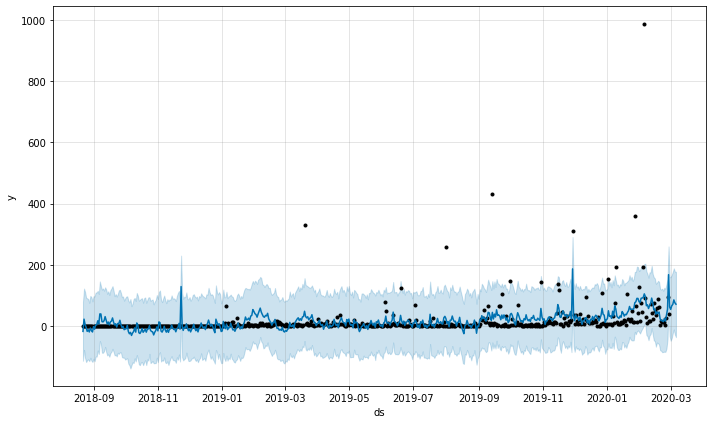

In [39]:
print('Olist price       = {}'.format(o_pred[0]))
print('Competition price = {}'.format(c_pred[0]))
print('Shipping value    = {}'.format(f_pred[0]))
m.plot(fcst)
plt.show()

In [40]:
df_cv = cross_validation(m, horizon='15 days')
df_p = performance_metrics(df_cv)

INFO:fbprophet:Making 24 forecasts with cutoffs between 2019-08-24 12:00:00 and 2020-02-13 00:00:00
INFO:fbprophet:Skipping MAPE because y close to 0


In [41]:
df_p

,horizon,mse,rmse,mae,mdape,coverage
0,1 days 12:00:00,794.194616,28.181459,21.149342,1.147785,0.944444
1,2 days 00:00:00,1096.592063,33.114831,24.394171,1.147785,0.916667
2,2 days 12:00:00,1354.796369,36.807559,25.318490,1.138049,0.916667
3,3 days 00:00:00,1700.045514,41.231608,26.820400,1.053906,0.916667
4,3 days 12:00:00,1421.665086,37.704974,23.134050,1.053906,0.944444
5,4 days 00:00:00,903.197045,30.053237,19.858236,0.875019,0.972222
6,4 days 12:00:00,886.671485,29.777029,21.562333,1.009824,0.916667
7,5 days 00:00:00,960.015776,30.984121,23.710110,1.009824,0.888889
8,5 days 12:00:00,8348.864258,91.372120,43.592035,1.095241,0.833333
9,6 days 00:00:00,8815.346788,93.890078,45.453106,0.934783,0.861111


## OLDS

In [ ]:
print('20% less then competition')
m.plot(fcst)
plt.show()

In [ ]:
#df_gr[df_gr.group_type_price == 'electronics_Celular_A'].head(4)
df_gr[(df_gr.orders>0) & (df_gr.freight_value.isnull())].head(4)


In [ ]:
fcst.tail(7)[['ds','delta_price','yhat']]

In [ ]:
print('40% less then competition')
m.plot(fcst)
plt.show()

In [ ]:
fcst.tail(7)[['ds','delta_price','yhat']]

In [ ]:
print('equal to competition')
m.plot(fcst)
plt.show()

In [ ]:
fcst.tail(7)[['ds','delta_price','yhat']]

In [ ]:
print('20% above competition')
m.plot(fcst)
plt.show()

In [ ]:
fcst.tail(7)[['ds','delta_price','yhat']]

### TODO: Parameters Search + modelling Competition Prices, Olist Prices and Shipping Values + calculate estimated reward.
Try to calculate the estimated rewards based on the final prices;  
Use grid or random search for parameters to optimize reward;  